In [1]:
import json
from urllib.request import urlopen

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import rasterio
from IPython.display import display
from mapa import (convert_array_to_stl, convert_tiff_to_stl,
                  split_array_into_tiles)
from matplotlib import cm
from matplotlib.ticker import LinearLocator
from PIL import Image, ImageDraw, ImageFont
from pyproj import Transformer
from rasterio import features
from rasterio.enums import Resampling
from shapely import Point
from tqdm.notebook import tqdm
from utils import *

In [2]:
pne,band = load_raster_data('../GEODATA/pne_emprise.tif',return_band1=True) 
transform = pne.transform

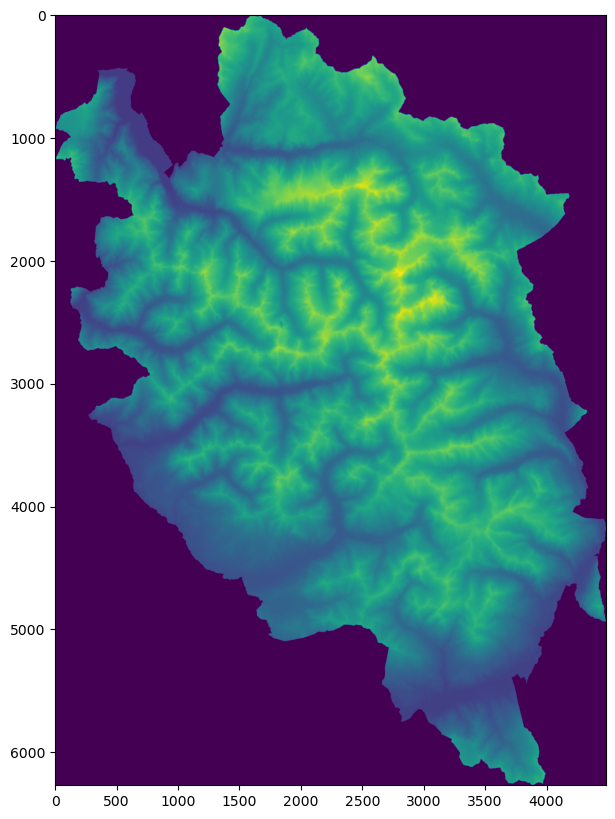

In [3]:
upscale_factor = 2
band = pne.read(
        out_shape=(
            pne.count,
            int(pne.height * upscale_factor),
            int(pne.width * upscale_factor)
        ),
        resampling=Resampling.bilinear
    )[0]

# scale image transform
transform = pne.transform * pne.transform.scale(
    (pne.width / band.shape[-1]),
    (pne.height / band.shape[-2])
)

fig,ax = plt.subplots(1,figsize=(10,10))
ax.imshow(band)

In [4]:
randos = gpd.read_file('../GEODATA/randos_pne.geojson')
randos = randos.explode()
assert randos.crs.to_epsg() == 2154 #check if data use lambert projection

C:\Users\jacqu\AppData\Local\Temp\ipykernel_9480\1227092741.py:2: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  randos = randos.explode()


  0%|          | 0/1483 [00:00<?, ?it/s]

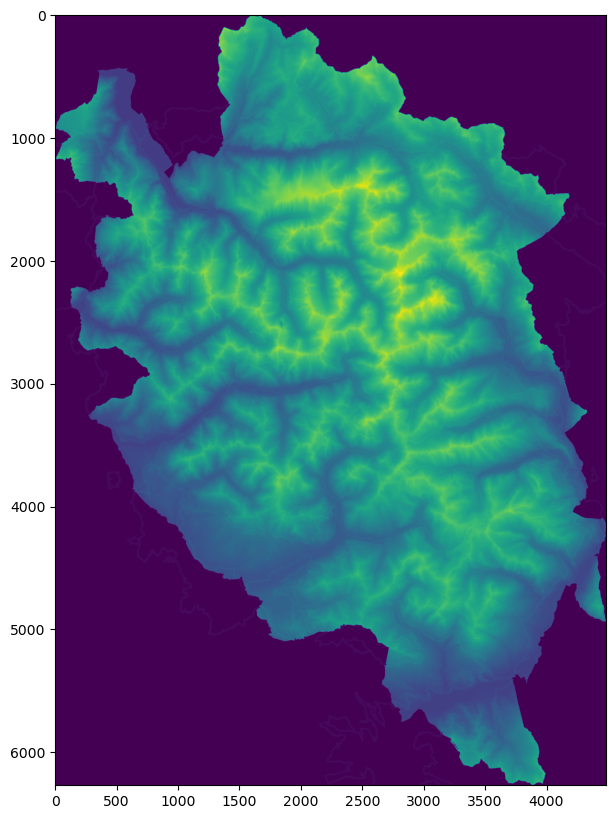

In [5]:
band1_with_data = extrude_geometries(randos, pne, band,buffer_size=100,extrusion_height=100,shape=band.shape,transform=transform)

fig,ax = plt.subplots(1,figsize=(10,10))
ax.imshow(band1_with_data)

In [6]:

query ="""
[out:json];
node
  [natural=peak]
  (44.499444,5.818634,45.193651,6.697540);
out;
"""
api_url = "https://overpass-api.de/api/interpreter"
data = json.load(urlopen(api_url,query.encode("utf-8")))
transformer = Transformer.from_crs("EPSG:4326", "EPSG:2154")




In [7]:
text_to_display = [(node["tags"]["name"],transformer.transform(node["lat"],node["lon"])) for node in data["elements"] if "name" in node['tags']]
text_to_display = [ (text,(x,y),list(pne.sample([(x,y)],1))[0][0]) for text, (x, y) in text_to_display]
text_to_display = [ (text,(x,y),altitude) for text, (x, y),altitude in text_to_display if altitude >0]

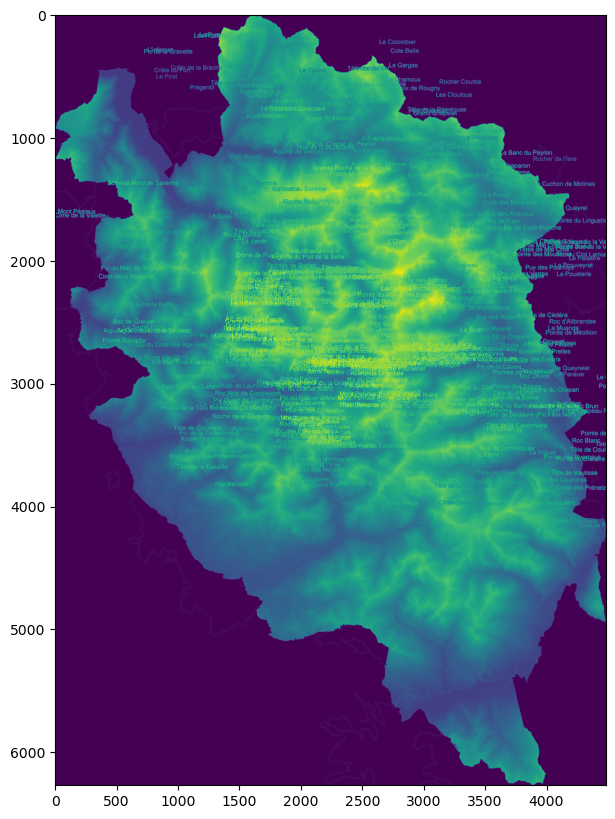

In [14]:
band_with_text = extrude_text_in_raster(pne,band1_with_data,text_to_display,("arial",50),extrusion_height=0,text_align="center",upscale_factor=upscale_factor)


fig,ax = plt.subplots(1,figsize=(10,10))
ax.imshow(band_with_text)

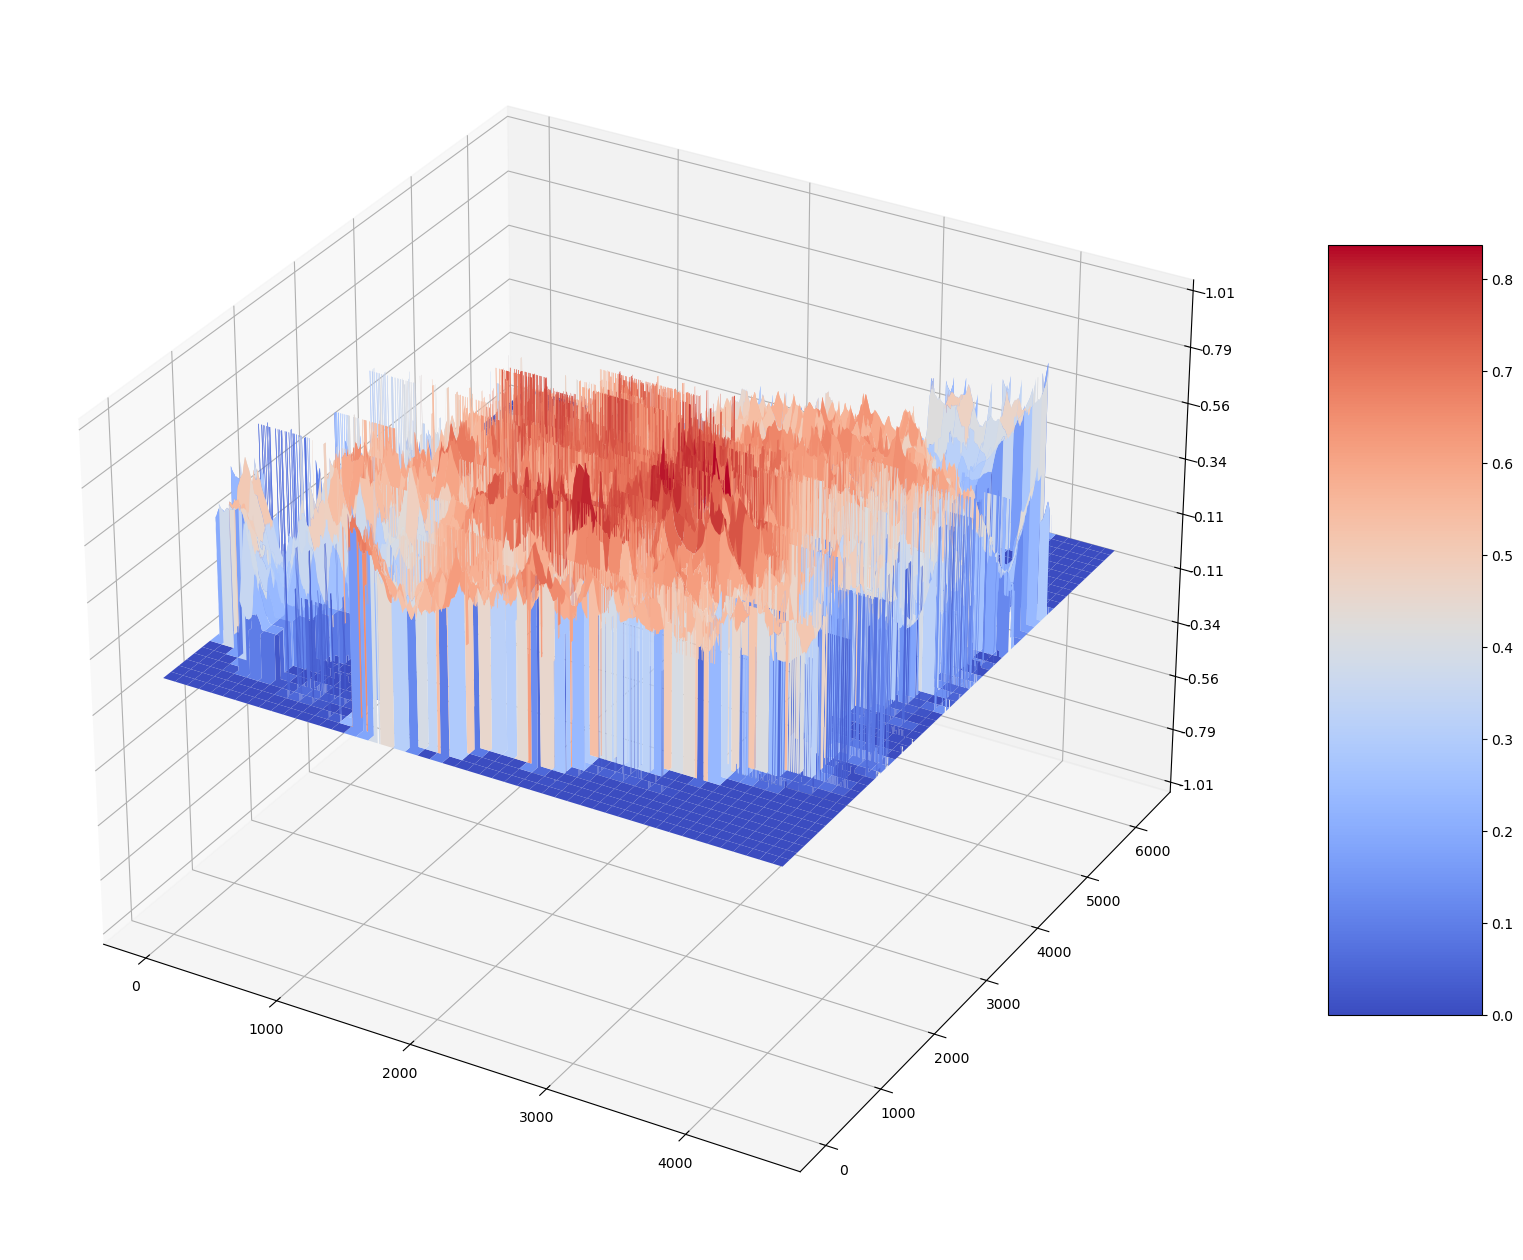

In [15]:


fig, ax = plt.subplots(subplot_kw={"projection": "3d"},figsize=(20,20))

# Make data.
X, Y = np.meshgrid(range(0,band_with_text.shape[1]),range(0,band_with_text.shape[0]) )

# Plot the surface.
surf = ax.plot_surface(X, Y, band_with_text/band_with_text.max(), cmap=cm.coolwarm,
                       linewidth=0, antialiased=True)

# Customize the z axis.
ax.set_zlim(-1.01, 1.01)
ax.zaxis.set_major_locator(LinearLocator(10))
# A StrMethodFormatter is used automatically
ax.zaxis.set_major_formatter('{x:.02f}')

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

In [ ]:
new_dataset = rasterio.open(
    'new.tif',
    'w',
    driver='GTiff',
    height=band_with_text.shape[0],
    width=band_with_text.shape[1],
    count=1,
    dtype=band_with_text.dtype,
    crs=pne.crs,
    transform=transform,

)
new_dataset.write(band_with_text, 1)
new_dataset.close()

In [26]:
convert_array_to_stl(
    band_with_text/band_with_text.max(),
    desired_size=Point(600, 600),
    output_file="test.stl",
    as_ascii=False,
    z_scale=1.3, # vertical scale
    z_offset=4, # size of the plateau
    max_res=False,
    elevation_scale=20
)

INFO:mapa:🎉  successfully generated STL file: c:\Users\jacqu\Dropbox\Projets\2024\Carte Ecrins\test_with_rasterio\test.stl


WindowsPath('test.stl')